In this work, you will use the APIs of PyG and DGL to implement some basic functions.

You need to run the following commands to install the GNN libraries (Only CPU version).

In [7]:
# !pip install  dgl -f https://data.dgl.ai/wheels/repo.html
# !pip install torch_geometric
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.1+cpu.html


^C



The most popular GNN models can be written as follows:

$$
h_i^{(l+1)}=\sigma(b^{(l)}+\sum_{j\in\mathcal{N}(i)}e_{ij}h_j^{(l)}W^{(l)})
$$

where $h_i^{(l+1)}$ is the output feature, $\sigma$ is the activation function, $e_{ij}$ is the edge weight, $W^{(l)}$ is the learnable parameters, $b^{(l)
}$ is the bias.

First, you will use the PyTorch-Geometric(PyG) to implement this convolution layer.

In [23]:
import torch
import torch.nn as nn
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import add_self_loops
class PyG_conv(MessagePassing):
  def __init__(self,in_channel,out_channel,):
    super(PyG_conv, self).__init__(aggr='add')
    self.in_channel = in_channel
    self.out_channel = out_channel
    self.W = nn.Parameter(torch.ones((in_channel, out_channel)))
    self.b = nn.Parameter(torch.ones(out_channel))

  def forward(self, x, edge_index, edge_weight):
    # Your code here
     
    # End code here

  def message(x, edge_weight):
    # Your code here
    
    # End code here


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 30)

In [43]:
class PyG_conv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(PyG_conv, self).__init__(aggr='add', flow='source_to_target')
        # "Add" aggregation (Step 5).
        # flow='source_to_target' 表示消息从源节点传播到目标节点
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index, edge_weight):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        # row, col = edge_index
        # deg = degree(col, x.size(0), dtype=x.dtype)
        # deg_inv_sqrt = deg.pow(-0.5)
        # norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x,  edge_weight=edge_weight) 

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]
        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j
    
    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]

        # Step 5: Return new node embeddings.
        return aggr_out


You may run the following code to check the correctness.

In [44]:
import torch
import numpy as np
edge_index = torch.tensor([[0,1,1,2,2,4],[2,0,2,3,4,3]])
x = torch.ones((5, 8))
edge_weight = 2 * torch.ones(6)
conv = PyG_conv(8, 4)
output = conv(x, edge_index, edge_weight)
print(output)
assert np.allclose(output.detach().numpy(), [[17., 17., 17., 17.],
                      [ 1.,  1.,  1.,  1.],
                      [33., 33., 33., 33.],
                      [33., 33., 33., 33.],
                      [17., 17., 17., 17.]])

AttributeError: type object '_empty' has no attribute 'view'

In [8]:
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

class CustomGNNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGNNConv, self).__init__(aggr='add')  # 使用 "Add" 聚合
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W = Parameter(torch.Tensor(in_channels, out_channels))
        self.b = Parameter(torch.Tensor(out_channels))
    #     self.reset_parameters()
    # 
    # def reset_parameters(self):
    #     torch.nn.init.xavier_uniform_(self.W)
    #     torch.nn.init.zeros_(self.b)

    def forward(self, x, edge_index, edge_weight = edge_weight):
        # 第一步：给邻接矩阵添加自环
        # edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        # if edge_weight is not None:
        #     self_loops_weight = torch.ones(x.size(0)).to(edge_weight.device)
        #     edge_weight = torch.cat([edge_weight, self_loops_weight])
        x_p = self.propagate(edge_index, x=x, edge_weight=edge_weight)
        # 第二步：开始传播消息
        return x_p

    def message(self, x, edge_index, edge_weight):
        # Step 3: 计算消息
        row, col = edge_index
        if edge_weight is None:
            return x[col]
        else:
            return edge_weight.view(-1, 1) * x[col]

    def update(self, aggr_out):
        # Step 4: 更新节点特征
        return aggr_out @ self.W + self.b

# 示例边索引和特征
edge_index = torch.tensor([[0, 1, 1, 2, 2, 4], [2, 0, 2, 3, 4, 3]], dtype=torch.long)
x = torch.ones((5, 8))  # 5 个节点，每个节点有 8 个特征
edge_weight = 2 * torch.ones(6)  # 边权重
from torch_geometric.data import Data
data = Data(x=x, edge_index=edge_index)# 定义并应用自定义卷积层
conv = CustomGNNConv(in_channels=8, out_channels=4)
output = conv(x, edge_index, edge_weight=edge_weight)

print(output)
import numpy as np
assert np.allclose(output.detach().numpy(), [[17., 17., 17., 17.],
                      [ 1.,  1.,  1.,  1.],
                      [33., 33., 33., 33.],
                      [33., 33., 33., 33.],
                      [17., 17., 17., 17.]])

tensor([[7.4094e-27, 3.7162e-42, 0.0000e+00, 0.0000e+00],
        [2.4612e-27, 1.2387e-42, 0.0000e+00, 0.0000e+00],
        [1.2358e-26, 6.1937e-42, 0.0000e+00, 0.0000e+00],
        [1.2358e-26, 6.1937e-42, 0.0000e+00, 0.0000e+00],
        [7.4094e-27, 3.7162e-42, 0.0000e+00, 0.0000e+00]],
       grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [5]:
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

class CustomGNNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGNNConv, self).__init__(aggr='add')  # "Add" aggregation (Step 5)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W = Parameter(torch.Tensor(in_channels, out_channels))
        self.b = Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.W)
        torch.nn.init.zeros_(self.b)

    def forward(self, x, edge_index, edge_weight=None):
        # Step 1: Add self-loops to the adjacency matrix
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Start propagating messages
        return self.propagate(edge_index, x=x, edge_weight=edge_weight)

    def message(self, x_j, edge_weight):
        # Step 3: Compute messages
        if edge_weight is None:
            return x_j
        else:
            return edge_weight.view(-1, 1) * x_j

    def update(self, aggr_out, x):
        # Step 4: Update node features
        return F.relu(aggr_out @ self.W + self.b)

# Sample edge_index and features
edge_index = torch.tensor([[0, 1, 1, 2, 2, 4], [2, 0, 2, 3, 4, 3]], dtype=torch.long)
x = torch.ones((5, 8))  # 5 nodes with 8 features each
edge_weight = 2 * torch.ones(6)  # edge weights

# Define and apply the custom convolution layer
conv = CustomGNNConv(in_channels=8, out_channels=4)
output = conv(x, edge_index, edge_weight=edge_weight)

print(output)


RuntimeError: The size of tensor a (6) must match the size of tensor b (11) at non-singleton dimension 0

In [12]:
import torch
from torch import Tensor
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
torch.manual_seed(42)

class GraphConv(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int):
        super(GraphConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.lin.weight)
        torch.nn.init.zeros_(self.bias)

    def forward(self, x: Tensor, edge_index: Tensor):
        # Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Start propagating messages.
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, norm=norm)

    def message(self, x_j: Tensor, norm: Tensor) -> Tensor:   
        # Normalize node features.
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out: Tensor):
        # Add bias after aggregation.
        biased = self.lin(aggr_out) + self.bias
        return biased

from torch_geometric.data import Data

def test_basic():
    # init test
    in_channels = 16
    out_channels = 32
    conv = GraphConv(in_channels, out_channels)

    # prepare input data
    x = torch.randn(4, in_channels) # 4x16
    edge_index = torch.tensor([[0, 1, 1, 2],
                               [1, 0, 2, 1]], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)

    # foiward test
    out = conv(data.x, data.edge_index)
    assert out.size() == (4, out_channels)

    # backward test
    if torch.cuda.is_available():
        conv = conv.cuda()
        data = data.cuda()
    out.mean().backward()
    assert conv.lin.weight.grad is not None
    assert conv.bias.grad is not None

def test_reset_parameters():
    # init test
    in_channels = 16
    out_channels = 32
    conv = GraphConv(in_channels, out_channels)

    # test parameter initialization
    conv.reset_parameters()
    assert torch.allclose(conv.bias, torch.zeros(out_channels))
    lin_weight = conv.lin.weight
    assert torch.allclose(lin_weight, lin_weight.data)

Now, you will implement the same functions with DGL.

In [41]:
import dgl
import dgl.function as fn

class DGL_conv(nn.Module):
  def __init__(self, in_channel, out_channel):
    self.in_channel = in_channel
    self.out_channel = out_channel
    #nn.Parameter将一个不可训练的tensor转换成可以训练的类型parameter，并将这个parameter绑定到这个module里面。
    self.W = nn.Parameter(torch.ones(in_channel, out_channel)) 
    self.b = nn.Parameter(torch.ones(out_channel))

  def forward(self, g, h):
    # Your code here
    g.update_all(fn.u_mul_e('h',self.W),fn.sum)
    
    
    return h

    # End code here

Also, you can also run the code below to check the correctness.

In [ ]:
src = torch.tensor([0, 1, 1, 2, 2, 4])
dst = torch.tensor([2, 0, 2, 3, 4, 3])
h = torch.ones((5, 8))
g = dgl.graph((src, dst))
edge_weight = 2 * torch.ones(6)
conv = DGL_conv(8, 4)
output = conv(g, h, edge_weight)
import numpy as np
assert np.allclose(output.detach().numpy(), [[17., 17., 17., 17.],
                      [ 1.,  1.,  1.,  1.],
                      [33., 33., 33., 33.],
                      [33., 33., 33., 33.],
                      [17., 17., 17., 17.]])

## Test in tutorials of DGL (graph-centric)
1. graph example


Graph(num_nodes=4, num_edges=4,
      ndata_schemes={}
      edata_schemes={})


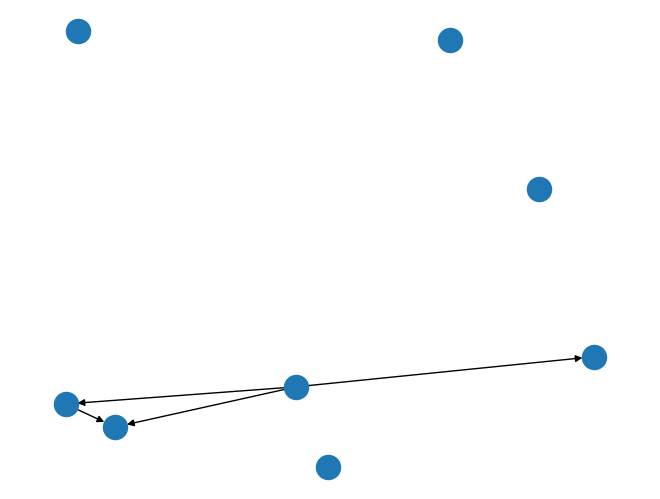

In [9]:
import dgl
import torch as th
from matplotlib import pyplot as plt
import networkx as nx
u, v = th.tensor([0, 0, 0, 1]), th.tensor([1, 2, 3, 3])
g = dgl.graph((u, v))
print(g) # 图中节点的数量是DGL通过给定的图的边列表中最大的点ID推断所得出的
g = dgl.graph((u, v), num_nodes=8)
nx.draw(g.to_networkx(),with_labels=False)#可视化图 to_networkx()
plt.show()

2. heterogeneous graph

In [10]:

from matplotlib import pyplot as plt
import networkx as nx
g = dgl.heterograph({
   ('drug', 'interacts', 'drug'): (th.tensor([0, 1]), th.tensor([1, 2])),
   ('drug', 'interacts', 'gene'): (th.tensor([0, 1]), th.tensor([2, 3])),
   ('drug', 'treats', 'disease'): (th.tensor([1]), th.tensor([2]))
})
g.nodes['drug'].data['hv'] = th.ones(3, 1)
eg = dgl.edge_type_subgraph(g, [('drug', 'interacts', 'drug'),
                                ('drug', 'treats', 'disease')])
print(eg)
# eg.nodes['drug'].data['hv']
nx.draw(g.to_networkx(),with_labels=False)#可视化图
plt.show()

Graph(num_nodes={'disease': 3, 'drug': 3},
      num_edges={('drug', 'interacts', 'drug'): 2, ('drug', 'treats', 'disease'): 1},
      metagraph=[('drug', 'drug', 'interacts'), ('drug', 'disease', 'treats')])


DGLError: dgl.to_networkx only supports homogeneous graphs.

In [11]:
#将图数据放在GPU，dgl的GPU版本还不能用
#没有安装GPU版本的，报错了，后续记得在新的虚拟环境中调好版本
import dgl 
import torch as th
device = th.device("cuda")
u, v = th.tensor([0, 1, 2]), th.tensor([2, 3, 4])
g = dgl.graph((u, v))
g.ndata['x'] = th.randn(5, 3)  # original feature is on CPU
# g.device

# cuda_g = g.to(device)  # accepts any device objects from backend framework
# cuda_g.device()
# cuda_g.ndata['x'].device       # feature data is copied to GPU too
# 
# # A graph constructed from GPU tensors is also on GPU
# u, v = u.to('cuda:0'), v.to('cuda:0')
# g = dgl.graph((u, v))
# g.device

In [12]:
import dgl.function as fn
import torch.nn as nn
node_feat_dim =3
out_dim =3
linear_src = nn.Parameter(torch.FloatTensor(size=(node_feat_dim, out_dim)))
linear_dst = nn.Parameter(torch.FloatTensor(size=(node_feat_dim, out_dim)))
out_src = g.ndata['feat'] @ linear_src
out_dst = g.ndata['feat'] @ linear_dst
g.srcdata.update({'out_src': out_src})
g.dstdata.update({'out_dst': out_dst})
g.apply_edges(fn.u_add_v('out_src', 'out_dst', 'out'))

KeyError: 'feat'

In [ ]:
import dgl.function as fn

for c_etype in G.cannical_etypes:
    srctype, etype,dsttype = c_etype

## Test in tutorials of PyG

1. Data

In [4]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

print(data)

Data(x=[3, 1], edge_index=[2, 4])


In [5]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0,1],
                           [1,0],
                           [1,2],
                           [2,1]],dtype = torch.long)
x = torch.tensor([[-1],[0],[1]],dtype = torch.long)
data = Data(x = x, edge_index =  edge_index.t().contiguous()) #contiguous()类似于深拷贝，如果不用这个，edge_index_t 变化，edge_index中的值也跟着变化

In [14]:
import dgl.nn as dglnn
in_feats = 9
out_feats = 9
num_heads = 5
# GraphConv
conv1 = dglnn.GraphConv(in_feats, out_feats)
x = conv1(g, x)

# GATConv
conv2 = dglnn.GATConv(in_feats, out_feats, num_heads)
x = conv2(g, x)

# SAGEConv
conv3 = dglnn.SAGEConv(in_feats, out_feats, 'mean')
x = conv3(g, x)

DGLError: There are 0-in-degree nodes in the graph, output for those nodes will be invalid. This is harmful for some applications, causing silent performance regression. Adding self-loop on the input graph by calling `g = dgl.add_self_loop(g)` will resolve the issue. Setting ``allow_zero_in_degree`` to be `True` when constructing this module will suppress the check and let the code run.

In [13]:
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

class CustomGNNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGNNConv, self).__init__(aggr='add')  # "Add" aggregation (Step 5)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W = Parameter(torch.Tensor(in_channels, out_channels))
        self.b = Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.W)
        torch.nn.init.zeros_(self.b)

    def forward(self, x, edge_index, edge_weight=None):
        # Step 1: Add self-loops to the adjacency matrix
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Start propagating messages
        return self.propagate(edge_index, x=x, edge_weight=edge_weight)

    def message(self, x_i, x_j, edge_weight):
        # Step 3: Compute messages
        if edge_weight is None:
            return x_j
        else:
            return edge_weight.view(-1, 1) * x_j

    def update(self, aggr_out):
        # Step 4: Update node features
        return F.relu(aggr_out @ self.W + self.b)

# Sample edge_index and features
edge_index = torch.tensor([[0, 1, 1, 2, 2, 4], [2, 0, 2, 3, 4, 3]], dtype=torch.long)
x = torch.ones((5, 8))  # 5 nodes with 8 features each
edge_weight = 2 * torch.ones(6)  # edge weights

# Define and apply the custom convolution layer
conv = CustomGNNConv(in_channels=8, out_channels=4)
output = conv(x, edge_index, edge_weight=edge_weight)

print(output)


RuntimeError: The size of tensor a (6) must match the size of tensor b (11) at non-singleton dimension 0

In [16]:
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

class CustomGNNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGNNConv, self).__init__(aggr='add')  # 使用 "Add" 聚合
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W = Parameter(torch.Tensor(in_channels, out_channels))
        self.b = Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.W)
        torch.nn.init.zeros_(self.b)

    def forward(self, x, edge_index, edge_weight=None):
        # 第一步：给邻接矩阵添加自环
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        
        if edge_weight is not None:
            self_loops_weight = torch.ones(x.size(0)).to(edge_weight.device)
            edge_weight = torch.cat([edge_weight, self_loops_weight])

        # 第二步：开始传播消息
        return self.propagate(edge_index, x=x, edge_weight=edge_weight)

    def message(self, x, edge_index, edge_weight):
        # Step 3: 计算消息
        row, col = edge_index
        if edge_weight is None:
            return x[col]
        else:
            return edge_weight.view(-1, 1) * x[col]

    def update(self, aggr_out):
        # Step 4: 更新节点特征
        return aggr_out @ self.W + self.b

# 示例边索引和特征
edge_index = torch.tensor([[0, 1, 1, 2, 2, 4], [2, 0, 2, 3, 4, 3]], dtype=torch.long)
x = torch.ones((5, 8))  # 5 个节点，每个节点有 8 个特征
edge_weight = 2 * torch.ones(6)  # 边权重

# 定义并应用自定义卷积层
conv = CustomGNNConv(in_channels=8, out_channels=4)
output = conv(x, edge_index, edge_weight=edge_weight)

print(output)


tensor([[ -1.5440,  -8.8577,  -3.8916,  -9.4477],
        [ -0.5147,  -2.9526,  -1.2972,  -3.1492],
        [ -2.5734, -14.7628,  -6.4861, -15.7462],
        [ -2.5734, -14.7628,  -6.4861, -15.7462],
        [ -1.5440,  -8.8577,  -3.8916,  -9.4477]], grad_fn=<AddBackward0>)
